# Pre-process data and calculate arithmetic and geometric mean

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean
from scipy.stats import gaussian_kde
import re

In [2]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 11,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Special character

In [3]:
mu = chr(956)
mu

'μ'

# BacDive

In [4]:
df_bacd = pd.read_csv('../preprocess/New_Data.csv')
df_bacd.head()

,ID,designation_header,strain_number_header,is_type_strain_header,species,Cell length (µm),Cell Width (µm),Cell Shape,Reference,NCBI ID
0,159837.0,OUC007,"KCTC 52933, MCCC 1K03450, OUC007",1.0,Abyssibacter profundi,1.7-1.9,0.4-0.6,rod-shaped,66716.0,2182787.0
1,132478.0,L81,"DSM 29592, JCM 30920",1.0,Abyssivirga alkaniphila,2.0-5.0,0.5,rod-shaped,43989.0,1675854.0
2,24718.0,FYK2218,"DSM 28897, KCTC 12899, NBRC 101209",1.0,Acanthopleuribacter pedis,2.4-4.7,0.7-1,rod-shaped,32501.0,442870.0
3,7517.0,CSC,"DSM 14247, CCUG 49701, NBRC 107788, CIP 109141",1.0,Acaricomes phytoseiuli,1-1.5,0.5-0.8,coccus-shaped,31628.0,291968.0
4,134101.0,Z7,"JCM 12359, AS1.5012",1.0,Acetanaerobacterium elongatum,6,0.3,rod-shaped,31285.0,258515.0


In [5]:
df_bacd.shape

(5284, 10)

Drop records without ID

In [6]:
df_bacd = df_bacd.dropna(subset=['ID']).astype({'ID': int})
df_bacd.shape

(5216, 10)

Drop records without reference 

In [7]:
df_bacd = df_bacd.dropna(subset=['Reference']).astype({'Reference': int})
df_bacd.shape

(5018, 10)

Fix two typos

In [8]:
df_bacd[df_bacd['Cell Width (µm)'] == '0.3.0.6']

,ID,designation_header,strain_number_header,is_type_strain_header,species,Cell length (µm),Cell Width (µm),Cell Shape,Reference,NCBI ID
3714,158646,1-32,"KCTC 52859, CCTCC AB 2017084",1.0,Pedobacter mongoliensis,1-2,0.3.0.6,rod-shaped,65371,NaN


In [9]:
df_bacd.at[3714, 'Cell Width (µm)'] = '0.3-0.6'

In [10]:
df_bacd[df_bacd['Cell Width (µm)'] == '2.0-4-0']

,ID,designation_header,strain_number_header,is_type_strain_header,species,Cell length (µm),Cell Width (µm),Cell Shape,Reference,NCBI ID
2221,1511,YKJ-13,"DSM 18867, CIP 107405, JCM 10872, KCCM 80002",1.0,Jeotgalibacillus alimentarius,1.0-1.2,2.0-4-0,rod-shaped,23065,135826.0


In [11]:
df_bacd.at[2221, 'Cell Width (µm)'] = '2.0-4.0'

NCBI TaxID

In [12]:
df_bacd['TaxID'] = df_bacd['NCBI ID'].apply(lambda x: x if np.isnan(x) else str(int(x)))

Drop records without NCBI TaxID.

In [13]:
df_bacd.drop(columns=['NCBI ID'], inplace=True)

### Cell size data

Check missing data

In [14]:
df_bacd.shape

(5018, 10)

In [15]:
df_bacd['Cell length (µm)'].dropna().shape[0]

5018

In [16]:
df_bacd['Cell Width (µm)'].dropna().shape[0]

4797

For records without width

In [17]:
df_ = df_bacd[df_bacd['Cell Width (µm)'].isna()]
df_.shape[0]

221

In [18]:
df_['Cell Shape'].value_counts()

Cell Shape
coccus-shaped         103
rod-shaped             89
sphere-shaped           8
ovoid-shaped            2
pleomorphic-shaped      2
star-shaped             2
oval-shaped             1
filament-shaped         1
spiral-shaped           1
Name: count, dtype: int64

For coccus- or shpere-shaped cells, let width = length.

In [19]:
lengths = df_bacd[df_bacd['Cell Width (µm)'].isna() & df_bacd['Cell Shape'].isin([
    'coccus-shaped', 'sphere-shaped'])]['Cell length (µm)']

In [20]:
# for idx, val in lengths.iteritems():
for idx, val in lengths.items():
    df_bacd.at[idx, 'Cell Width (µm)'] = val

Drop records of other cell shapes.

In [21]:
df_bacd.dropna(subset=['Cell Width (µm)'], inplace=True)
df_bacd.shape[0]

4908

Standardize the format of length and width values.

- For ranges (e.g., `0.2-0.5`), take geometric mean.
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [22]:
def size_to_num(size):
    """Convert a size string into a number.
    """
    if size.endswith(' µ'):
        size = size[:-2]
    if size.endswith(' mm'):
        size = size[:-3]
    if '-' in size:
        return gmean([float(x) for x in size.split('-')])
    elif size.startswith(('>', '<')):
        return float(size[1:])
    else:
        return float(size)

In [23]:
def size_to_num2(size):
    """Convert a size string into a number.
    Take arithmetic mean instead of geometric mean
    """
    if size.endswith(' µ'):
        size = size[:-2]
    if size.endswith(' mm'):
        size = size[:-3]
    if '-' in size:
        return np.mean([float(x) for x in size.split('-')])
    elif size.startswith(('>', '<')):
        return float(size[1:])
    else:
        return float(size)

In [24]:
def size_to_range(size):
    """Convert a size string into a range (tuple).
    """
    if size.endswith(' µ'):
        size = size[:-2]
    if size.endswith(' mm'):
        size = size[:-3]
    if '-' in size:
        rng = [float(x) for x in size.split('-')]
        return [rng[0], rng[-1]]
    elif size.startswith(('>', '<')):
        return [float(size[1:]), float(size[1:])]
    else:
        return [float(size), float(size)]

In [25]:
def order(row, metric):
    metrics = {'length': 'width', 'width': 'length'}
    if np.isclose(gmean(row[f'{metric}_ranges']), row[f'{metric}_gmean']):
        return row[f'{metric}_ranges']
    else:
        return row[f'{metrics[metric]}_ranges']

In [26]:
df_bacd['length_gmean'] = df_bacd['Cell length (µm)'].astype(str).apply(size_to_num)
df_bacd['width_gmean'] = df_bacd['Cell Width (µm)'].astype(str).apply(size_to_num)

In [27]:
df_bacd['length_amean'] = df_bacd['Cell length (µm)'].astype(str).apply(size_to_num2)
df_bacd['width_amean'] = df_bacd['Cell Width (µm)'].astype(str).apply(size_to_num2)

Ensure that length is greater than or equal to width.

In [28]:
df_bacd[['length_gmean', 'width_gmean']] = df_bacd[['length_gmean', 'width_gmean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

In [29]:
df_bacd[['length_amean', 'width_amean']] = df_bacd[['length_amean', 'width_amean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

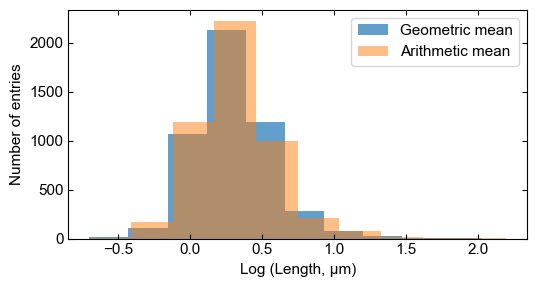

In [30]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bacd['length_gmean'].apply(np.log10), alpha = 0.7, label = 'Geometric mean')
plt.hist(df_bacd['length_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Length, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

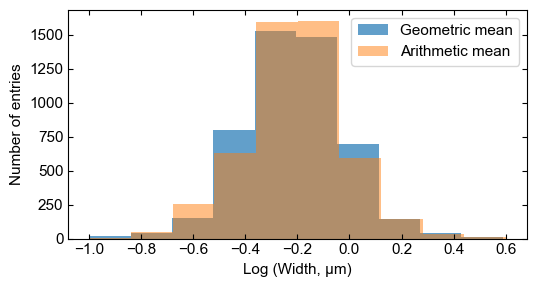

In [31]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bacd['width_gmean'].apply(np.log10), alpha = 0.7, label = 'Geometric mean')
plt.hist(df_bacd['width_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Width, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

Calculate volume and surface area.

In [32]:
df_bacd['volume_gmean'] = np.pi * (df_bacd['width_gmean'] / 2) ** 2 * ((4 / 3) * (df_bacd['width_gmean'] / 2) + (df_bacd['length_gmean'] - df_bacd['width_gmean']))
df_bacd['surface_gmean'] = 2 * np.pi * (df_bacd['width_gmean'] / 2) * (2 * (df_bacd['width_gmean'] / 2) + (df_bacd['length_gmean'] - df_bacd['width_gmean']))
# df_bacd['svratio_gmean'] = df_bacd['surface_gmean'] / df_bacd['volume_gmean']
# df_bacd['vsratio_gmean'] = df_bacd['volume_gmean'] / df_bacd['surface_gmean']

In [33]:
df_bacd['volume_amean'] = np.pi * (df_bacd['width_amean'] / 2) ** 2 * ((4 / 3) * (df_bacd['width_amean'] / 2) + (df_bacd['length_amean'] - df_bacd['width_amean']))
df_bacd['surface_amean'] = 2 * np.pi * (df_bacd['width_amean'] / 2) * (2 * (df_bacd['width_amean'] / 2) + (df_bacd['length_amean'] - df_bacd['width_amean']))
# df_bacd['svratio_amean'] = df_bacd['surface_amean'] / df_bacd['volume_amean']
# df_bacd['vsratio_amean'] = df_bacd['volume_amean'] / df_bacd['surface_amean']

Rename columns

In [34]:
df_bacd.rename(columns = {'Cell length (µm)': 'Length', 'Cell Width (µm)': 'Width', 'species': 'Name'}, 
               inplace = True)

Get ranges

In [35]:
df_bacd['length_ranges'] = df_bacd['Length'].astype(str).apply(size_to_range)
df_bacd['width_ranges'] = df_bacd['Width'].astype(str).apply(size_to_range)

Fix ranges

In [36]:
df_bacd['length_ranges_fix'] = df_bacd.apply(lambda x: order(x, 'length'), axis = 1)
df_bacd['width_ranges_fix'] = df_bacd.apply(lambda x: order(x, 'width'), axis = 1)

Save dataframe

In [37]:
df_bacd.to_csv('preprocess/data_bacdive.tsv', sep='\t')

# Pasteur Culture Collection (PCC)

As pointed out by Ferran, 'most of the strains with data correspond to prolate spheroids or spheres, which are not very different in the end, and using a diameter and speheres is a good approach'. 

**Therefore, we can assume a sphere shape but for the sake of standarization with the BacDive data, we will simplifie the cell shape as capsules.**

For sphere/spheroid-shaped cells, let width = length

In [38]:
df_pcc = pd.read_csv('../preprocess/data_cyanobacteria_taxID.tsv', sep = '\t', index_col = 0)

In [39]:
df_pcc.shape

(225, 3)

In [40]:
df_pcc['width'] = df_pcc['length']

In [41]:
# Add shape column
df_pcc['shape'] = 'sphere/spheroid'

Standardize length and width values:

* For ranges (e.g., `4-8`), take geometric mean
* For minimum / maximum values, take boundary.
* There are some exceptions. The following code deals with exceptions.

In [42]:
df_pcc['length_gmean'] = df_pcc['length'].apply(size_to_num)
df_pcc['width_gmean'] = df_pcc['width'].apply(size_to_num)

In [43]:
df_pcc['length_amean'] = df_pcc['length'].apply(size_to_num2)
df_pcc['width_amean'] = df_pcc['width'].apply(size_to_num2)

Ensure that length is greater than or equal to width.

In [44]:
df_pcc[['length_gmean', 'width_gmean']] = df_pcc[['length_gmean', 'width_gmean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

In [45]:
df_pcc[['length_amean', 'width_amean']] = df_pcc[['length_amean', 'width_amean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

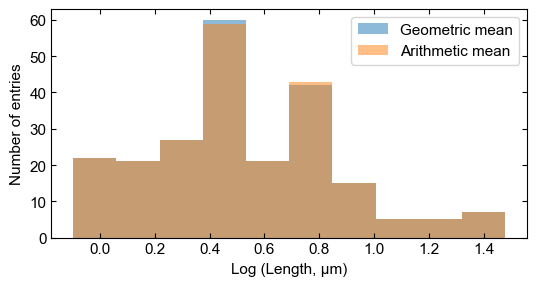

In [46]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_pcc['length_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_pcc['length_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Length, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

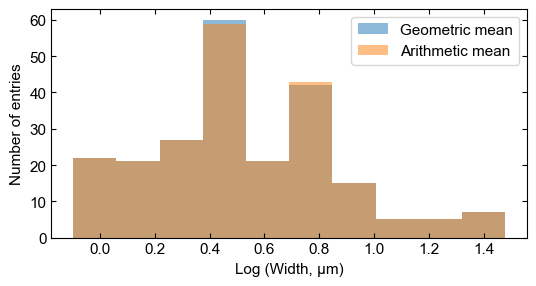

In [47]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_pcc['width_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_pcc['width_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Width, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

Calculate volume and surface area

In [48]:
df_pcc['volume_gmean'] = np.pi * (df_pcc['width_gmean'] / 2) ** 2 * ((4 / 3) * (df_pcc['width_gmean'] / 2) + (df_pcc['length_gmean'] - df_pcc['width_gmean']))
df_pcc['surface_gmean'] = 2 * np.pi * (df_pcc['width_gmean'] / 2) * (2 * (df_pcc['width_gmean'] / 2) + (df_pcc['length_gmean'] - df_pcc['width_gmean']))
# df_pcc['svratio_gmean'] = df_pcc['surface_gmean'] / df_pcc['volume_gmean']
# df_pcc['vsratio_gmean'] = df_pcc['volume_gmean'] / df_pcc['surface_gmean']

In [49]:
df_pcc['volume_amean'] = np.pi * (df_pcc['width_amean'] / 2) ** 2 * ((4 / 3) * (df_pcc['width_amean'] / 2) + (df_pcc['length_amean'] - df_pcc['width_amean']))
df_pcc['surface_amean'] = 2 * np.pi * (df_pcc['width_amean'] / 2) * (2 * (df_pcc['width_amean'] / 2) + (df_pcc['length_amean'] - df_pcc['width_amean']))
# df_pcc['svratio_amean'] = df_pcc['surface_amean'] / df_pcc['volume_amean']
# df_pcc['vsratio_amean'] = df_pcc['volume_amean'] / df_pcc['surface_amean']

Rename columns

In [50]:
df_pcc.rename(columns = {'length': 'Length', 'width': 'Width', 'spname': 'Name'}, 
               inplace = True)

Get ranges

In [51]:
df_pcc['length_ranges'] = df_pcc['Length'].astype(str).apply(size_to_range)
df_pcc['width_ranges'] = df_pcc['Width'].astype(str).apply(size_to_range)

Fix ranges

In [52]:
df_pcc['length_ranges_fix'] = df_pcc.apply(lambda x: order(x, 'length'), axis = 1)
df_pcc['width_ranges_fix'] = df_pcc.apply(lambda x: order(x, 'width'), axis = 1)

In [53]:
df_pcc.shape

(225, 17)

Save data

In [54]:
df_pcc.to_csv('preprocess/data_pcc.tsv', sep = '\t')

# PubMed

In [55]:
df_pubmed1 = pd.read_excel('../preprocess/100_microbes.xlsx')
df_pubmed1.shape

(100, 7)

Drop records without length and width

In [56]:
df_pubmed1 = df_pubmed1.dropna(subset = ['Length (mm)', 'Width (mm)'], how = 'all')
df_pubmed1.shape

(54, 7)

If shape is sphere, then length is the same as width

In [57]:
for i, row in df_pubmed1.iterrows():
    if re.findall('[Ss]phere', str(row['Shape'])):
        df_pubmed1.at[i, 'Width (mm)'] = df_pubmed1.at[i, 'Length (mm)']

Drop entries with no width

In [58]:
df_pubmed1.dropna(subset = ['Width (mm)'], inplace = True)

Drop entries present in BacDive

In [59]:
df_pubmed1 = df_pubmed1.drop([1, 12, 19, 20, 0, 33, 86, 90, 91])

In [60]:
df_pubmed1.shape

(40, 7)

In [61]:
df_pubmed2 = pd.read_excel('../preprocess/Small_and_giant_microbes.xlsx')
df_pubmed2.shape

(14, 6)

Correct data for Thiomargarita namibiensis.

In [62]:
df_pubmed2.at[13, 'Length (mm)'] = '100-300'

Add a new entry: [largest bacterium ever discovered](https://www.science.org/content/article/largest-bacterium-ever-discovered-has-unexpectedly-complex-cells?utm_source=Nature+Briefing&utm_campaign=f3a6c61808-briefing-dy-20220224&utm_medium=email&utm_term=0_c9dfd39373-f3a6c61808-43769453). Data from cell H, Table S2 of [preprint](https://www.biorxiv.org/content/10.1101/2022.02.16.480423v1). 

In [63]:
len(df_pubmed2)

14

In [64]:
# df_pubmed2 = df_pubmed2.append({'Small Microbes': 'Thiomargarita magnifica', 'Length (mm)': '9720',
#                 'Width (mm)': '30', 'Shape': 'rod', 'Genome': 'NaN', 
#                  'Reference': 'https://doi.org/10.1101/2022.02.16.480423'}, ignore_index = True)
df_pubmed2.loc[len(df_pubmed2)] = {'Small Microbes': 'Thiomargarita magnifica', 'Length (mm)': '9720',
                'Width (mm)': '30', 'Shape': 'rod', 'Genome': 'NaN', 
                 'Reference': 'https://doi.org/10.1101/2022.02.16.480423'}

Drop records without lenght AND width

In [65]:
df_pubmed2 = df_pubmed2.dropna(subset = ['Length (mm)', 'Width (mm)'], how = 'all')
df_pubmed2.shape

(15, 6)

In [66]:
# If shape is sphere, then length is the same as width
for i, row in df_pubmed2.iterrows():
    if re.findall('([Ss]phere)|(pear)', str(row['Shape'])):
        df_pubmed2.at[i, 'Width (mm)'] = df_pubmed2.at[i, 'Length (mm)']

In [67]:
# Drop records with no width
df_pubmed2 = df_pubmed2.dropna(subset = ['Width (mm)'])

In [68]:
df_pubmed2.shape

(14, 6)

Check if records are contained in BacDive

In [69]:
for i, row in df_pubmed2.iterrows():
    hit = df_bacd[df_bacd['Name'].str.contains(row['Small Microbes'])]
    if hit.shape[0] != 0:
        print('Hit')

None of the smalles or largest microbes are contained in the BacDIve dataset

In [70]:
# Drop columns irrelevant columns
df_pubmed1.drop(columns = ['All', 'Sampled'], inplace = True)
df_pubmed2.drop(columns = ['Genome'], inplace = True)

Rename columns

In [71]:
df_pubmed1.rename(columns = {'Organism': 'Name', 'Length (mm)': 'Length', 'Width (mm)': 'Width', 'Reference': 'reference'}, inplace = True)
df_pubmed2.rename(columns = {'Small Microbes': 'Name', 'Length (mm)': 'Length', 'Width (mm)': 'Width', 'Reference': 'reference'}, inplace = True)

Join datasets

In [72]:
df_pubmed = pd.concat([df_pubmed1, df_pubmed2])

In [73]:
df_pubmed.shape

(54, 5)

Standardize length and width values:

- For ranges (e.g., 4-8), take geometric mean
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [74]:
df_pubmed['length_gmean'] = df_pubmed['Length'].astype(str).apply(size_to_num)
df_pubmed['width_gmean'] = df_pubmed['Width'].astype(str).apply(size_to_num)

In [75]:
df_pubmed['length_amean'] = df_pubmed['Length'].astype(str).apply(size_to_num2)
df_pubmed['width_amean'] = df_pubmed['Width'].astype(str).apply(size_to_num2)

Ensure that length is greater than or equal to width.

In [76]:
df_pubmed[['length_gmean', 'width_gmean']] = df_pubmed[['length_gmean', 'width_gmean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

In [77]:
df_pubmed[['length_amean', 'width_amean']] = df_pubmed[['length_amean', 'width_amean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

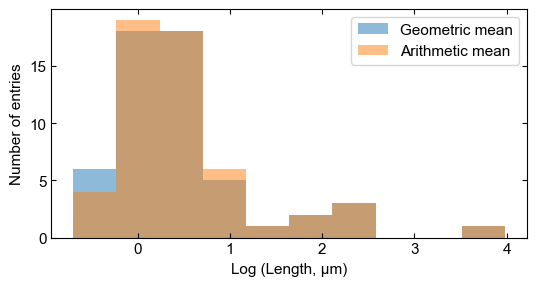

In [78]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_pubmed['length_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_pubmed['length_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Length, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

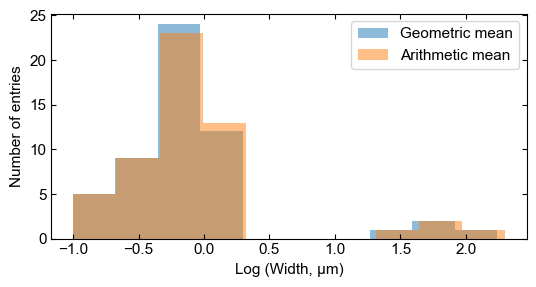

In [79]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_pubmed['width_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_pubmed['width_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Width, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

Calculate volume and surface area

In [80]:
df_pubmed['volume_gmean'] = np.pi * (df_pubmed['width_gmean'] / 2) ** 2 * ((4 / 3) * (df_pubmed['width_gmean'] / 2) + (df_pubmed['length_gmean'] - df_pubmed['width_gmean']))
df_pubmed['surface_gmean'] = 2 * np.pi * (df_pubmed['width_gmean'] / 2) * (2 * (df_pubmed['width_gmean'] / 2) + (df_pubmed['length_gmean'] - df_pubmed['width_gmean']))
# df_pubmed['svratio_gmean'] = df_pubmed['surface_gmean'] / df_pubmed['volume_gmean']
# df_pubmed['vsratio_gmean'] = df_pubmed['volume_gmean'] / df_pubmed['surface_gmean']

In [81]:
df_pubmed['volume_amean'] = np.pi * (df_pubmed['width_amean'] / 2) ** 2 * ((4 / 3) * (df_pubmed['width_amean'] / 2) + (df_pubmed['length_amean'] - df_pubmed['width_amean']))
df_pubmed['surface_amean'] = 2 * np.pi * (df_pubmed['width_amean'] / 2) * (2 * (df_pubmed['width_amean'] / 2) + (df_pubmed['length_amean'] - df_pubmed['width_amean']))
# df_pubmed['svratio_amean'] = df_pubmed['surface_amean'] / df_pubmed['volume_amean']
# df_pubmed['vsratio_amean'] = df_pubmed['volume_amean'] / df_pubmed['surface_amean']

Get ranges

In [82]:
df_pubmed['length_ranges'] = df_pubmed['Length'].astype(str).apply(size_to_range)
df_pubmed['width_ranges'] = df_pubmed['Width'].astype(str).apply(size_to_range)

Fix ranges

In [83]:
df_pubmed['length_ranges_fix'] = df_pubmed.apply(lambda x: order(x, 'length'), axis = 1)
df_pubmed['width_ranges_fix'] = df_pubmed.apply(lambda x: order(x, 'width'), axis = 1)

Save dataframe

In [84]:
# Set a new index
df_pubmed.set_index(np.arange(0, len(df_pubmed)), inplace = True)

In [85]:
df_pubmed.to_csv('preprocess/data_pubmed.tsv', sep = '\t')

# Bergey's manual

### Volume 1

In [86]:
df_bm1 = pd.read_csv('../preprocess/BMvol1.csv', sep = ',')
df_bm1.shape

(109, 8)

Drop entries without shape

In [87]:
df_bm1 = df_bm1.dropna(subset = ['Shape'])
df_bm1.shape

(109, 8)

Drop entries without length and width

In [88]:
df_bm1 = df_bm1.dropna(subset = ['Length', 'Width'], how = 'all')
df_bm1.shape

(109, 8)

Drop entries of subspecies

In [89]:
df_bm1 = df_bm1[df_bm1['Subspecies'] != 'Yes'].copy()
df_bm1.shape

(109, 8)

Make sure that spherical shapes have length and width

In [90]:
tmp = df_bm1[df_bm1['Shape'].str.contains('spher')]

In [91]:
tmp[tmp['Width'].isnull()].shape

(0, 8)

In [92]:
tmp[tmp['Width'].isnull()].shape

(0, 8)

In [93]:
df_bm1 = df_bm1.dropna(subset = ['Length', 'Width'], how = 'any')
df_bm1.shape

(105, 8)

Standardize length and width values:

- For ranges (e.g., 4-8), take geometric mean
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [94]:
df_bm1['length_gmean'] = df_bm1['Length'].astype(str).apply(size_to_num)
df_bm1['width_gmean'] = df_bm1['Width'].astype(str).apply(size_to_num)

In [95]:
df_bm1['length_amean'] = df_bm1['Length'].astype(str).apply(size_to_num2)
df_bm1['width_amean'] = df_bm1['Width'].astype(str).apply(size_to_num2)

Ensure that length is greater than or equal to width.

In [96]:
df_bm1[['length_gmean', 'width_gmean']] = df_bm1[['length_gmean', 'width_gmean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

In [97]:
df_bm1[['length_amean', 'width_amean']] = df_bm1[['length_amean', 'width_amean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

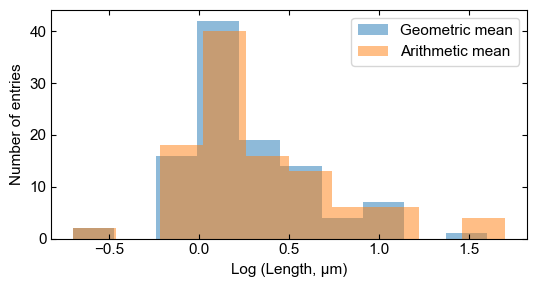

In [98]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bm1['length_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_bm1['length_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Length, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

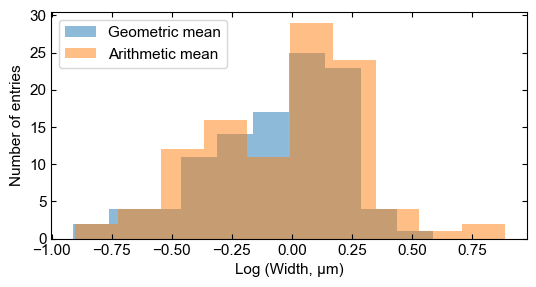

In [99]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bm1['width_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_bm1['width_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Width, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

Drop entries already present in bacdive

In [100]:
df_bm1 = df_bm1.drop([10, 11])

In [101]:
df_bm1.shape

(103, 12)

Calculate volume and surface area

In [102]:
df_bm1['volume_gmean'] = np.pi * (df_bm1['width_gmean'] / 2) ** 2 * ((4 / 3) * (df_bm1['width_gmean'] / 2) + (df_bm1['length_gmean'] - df_bm1['width_gmean']))
df_bm1['surface_gmean'] = 2 * np.pi * (df_bm1['width_gmean'] / 2) * (2 * (df_bm1['width_gmean'] / 2) + (df_bm1['length_gmean'] - df_bm1['width_gmean']))
# df_bm1['svratio_gmean'] = df_bm1['surface_gmean'] / df_bm1['volume_gmean']
# df_bm1['vsratio_gmean'] = df_bm1['volume_gmean'] / df_bm1['surface_gmean']

In [103]:
df_bm1['volume_amean'] = np.pi * (df_bm1['width_amean'] / 2) ** 2 * ((4 / 3) * (df_bm1['width_amean'] / 2) + (df_bm1['length_amean'] - df_bm1['width_amean']))
df_bm1['surface_amean'] = 2 * np.pi * (df_bm1['width_amean'] / 2) * (2 * (df_bm1['width_amean'] / 2) + (df_bm1['length_amean'] - df_bm1['width_amean']))
# df_bm1['svratio_amean'] = df_bm1['surface_amean'] / df_bm1['volume_amean']
# df_bm1['vsratio_amean'] = df_bm1['volume_amean'] / df_bm1['surface_amean']

Get ranges

In [104]:
df_bm1['length_ranges'] = df_bm1['Length'].astype(str).apply(size_to_range)
df_bm1['width_ranges'] = df_bm1['Width'].astype(str).apply(size_to_range)

Fix ranges

In [105]:
df_bm1['length_ranges_fix'] = df_bm1.apply(lambda x: order(x, 'length'), axis = 1)
df_bm1['width_ranges_fix'] = df_bm1.apply(lambda x: order(x, 'width'), axis = 1)

Save dataframe

In [106]:
# Set a new index
df_bm1.set_index(np.arange(0, df_bm1.shape[0]), inplace = True)

In [107]:
df_bm1.to_csv('preprocess/data_bm1.tsv', sep = '\t')

### Volume 4

In [108]:
df_bm4 = pd.read_csv('../preprocess/BMvol4.csv', sep = ',')
df_bm4.shape

(438, 8)

Drop entries without shape

In [109]:
df_bm4 = df_bm4.dropna(subset = ['Shape'])
df_bm4.shape

(408, 8)

Drop entries without length and width

In [110]:
df_bm4 = df_bm4.dropna(subset = ['Length', 'Width'], how = 'all')
df_bm4.shape

(401, 8)

Drop entries of subspecies

In [111]:
df_bm4 = df_bm4[df_bm4['Subspecies'] != 'Yes'].copy()
df_bm4.shape

(385, 8)

Make sure that spherical shapes have length and width.

In [112]:
tmp = df_bm4[df_bm4['Shape'].str.contains('spher')]

In [113]:
tmp[tmp['Width'].isnull()].shape

(0, 8)

In [114]:
tmp[tmp['Length'].isnull()].shape

(0, 8)

Drop entries without length or width

In [115]:
df_bm4 = df_bm4.dropna(subset = ['Length', 'Width'], how = 'any')
df_bm4.shape

(373, 8)

Standardize length and width values:

- For ranges (e.g., 4-8), take geometric mean
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [116]:
df_bm4['length_gmean'] = df_bm4['Length'].astype(str).apply(size_to_num)
df_bm4['width_gmean'] = df_bm4['Width'].astype(str).apply(size_to_num)

In [117]:
df_bm4['length_amean'] = df_bm4['Length'].astype(str).apply(size_to_num2)
df_bm4['width_amean'] = df_bm4['Width'].astype(str).apply(size_to_num2)

Ensure that length is greater than or equal to width.

In [118]:
df_bm4[['length_gmean', 'width_gmean']] = df_bm4[['length_gmean', 'width_gmean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

In [119]:
df_bm4[['length_amean', 'width_amean']] = df_bm4[['length_amean', 'width_amean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

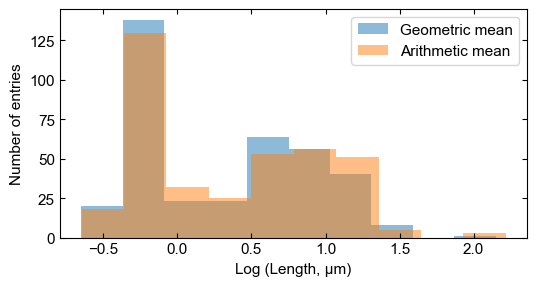

In [120]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bm4['length_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_bm4['length_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Length, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

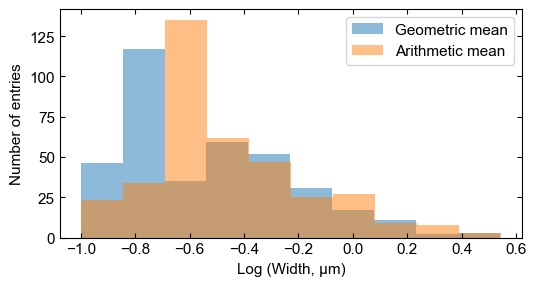

In [121]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bm4['width_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_bm4['width_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Width, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

Drop redundant entries

In [122]:
df_bm4.drop([55, 143, 144, 145], inplace = True)
df_bm4.at[142, 'Name'] = 'Leptospira genomospecies'

Drop species already present in BacDive

In [123]:
df_bm4 = df_bm4.drop([ 30, 31, 33,  47,  84,  95, 108, 109, 369, 370, 
                      374, 379, 392, 394, 397, 398, 399, 400, 401, 402, 403, 435, 436])

In [124]:
df_bm4.shape

(346, 12)

Calculate volume and surface area

In [125]:
df_bm4['volume_gmean'] = np.pi * (df_bm4['width_gmean'] / 2) ** 2 * ((4 / 3) * (df_bm4['width_gmean'] / 2) + (df_bm4['length_gmean'] - df_bm4['width_gmean']))
df_bm4['surface_gmean'] = 2 * np.pi * (df_bm4['width_gmean'] / 2) * (2 * (df_bm4['width_gmean'] / 2) + (df_bm4['length_gmean'] - df_bm4['width_gmean']))
# df_bm4['svratio_gmean'] = df_bm4['surface_gmean'] / df_bm4['volume_gmean']
# df_bm4['vsratio_gmean'] = df_bm4['volume_gmean'] / df_bm4['surface_gmean']

In [126]:
df_bm4['volume_amean'] = np.pi * (df_bm4['width_amean'] / 2) ** 2 * ((4 / 3) * (df_bm4['width_amean'] / 2) + (df_bm4['length_amean'] - df_bm4['width_amean']))
df_bm4['surface_amean'] = 2 * np.pi * (df_bm4['width_amean'] / 2) * (2 * (df_bm4['width_amean'] / 2) + (df_bm4['length_amean'] - df_bm4['width_amean']))
# df_bm4['svratio_amean'] = df_bm4['surface_amean'] / df_bm4['volume_amean']
# df_bm4['vsratio_amean'] = df_bm4['volume_amean'] / df_bm4['surface_amean']

Get ranges

In [127]:
df_bm4['length_ranges'] = df_bm4['Length'].astype(str).apply(size_to_range)
df_bm4['width_ranges'] = df_bm4['Width'].astype(str).apply(size_to_range)

Fix ranges

In [128]:
df_bm4['length_ranges_fix'] = df_bm4.apply(lambda x: order(x, 'length'), axis = 1)
df_bm4['width_ranges_fix'] = df_bm4.apply(lambda x: order(x, 'width'), axis = 1)

Save dataframe

In [129]:
# Set a new index
df_bm4.set_index(np.arange(0, df_bm4.shape[0]), inplace = True)

In [130]:
df_bm4.to_csv('preprocess/data_bm4.tsv', sep = '\t')

### Volume 5

In [131]:
df_bm5 = pd.read_excel('../preprocess/BMvol5.csv')
df_bm5.shape

(918, 7)

Drop entries without shape

In [132]:
df_bm5 = df_bm5.dropna(subset = ['shape'])
df_bm5.shape

(760, 7)

Drop entries without length and width


In [133]:
df_bm5 = df_bm5.dropna(subset = ['length mum', 'width mum'], how = 'all')
df_bm5.shape

(467, 7)

If shape is rods-coccus and there is a single value for cell dimension (length or width), add the remaining value (because the other shape is coccus ~ sphere)


In [134]:
tmp = df_bm5[df_bm5['shape'] == 'rods-coccus'][['length mum', 'width mum']]

In [135]:
tmp[tmp.isna().any(axis=1)]

,length mum,width mum


If shape is coccus-bacilli and there is a single value for cell dimension (length or width), add the remaining value (because the other shape is coccus ~ sphere)

In [136]:
tmp = df_bm5[df_bm5['shape'] == 'coccus-bacilli'][['length mum', 'width mum']]

In [137]:
tmp[tmp.isna().any(axis=1)]

,length mum,width mum
278,1.2-1.4,NaN


In [138]:
df_bm5.at[278, 'width mum'] = '1.2-1.4'

Correct some error: rods\s for rods


In [139]:
df_bm5[df_bm5['shape'] == 'rods ']

,rank,name,shape,length mum,width mum,diameter,Unnamed: 6
262,species,mycobacterium vanbaallenii,rods,1.4,0.7,NaN,NaN
322,species,mycobacterium hodleri,rods,1.8-2.3,1,NaN,NaN


In [140]:
df_bm5.at[262, 'shape'] = 'rods'
df_bm5.at[322, 'shape'] = 'rods'

Drop entries with only one value for cell dimension (length or width) as this is not helpful to calculate the volume or surface.

In [141]:
df_bm5 = df_bm5.dropna(subset = ['length mum', 'width mum'], how = 'any').copy()
df_bm5.shape

(426, 7)

Drop records with rank != species

In [142]:
df_bm5 = df_bm5[df_bm5['rank'].str.contains('species')].copy()
df_bm5.shape

(424, 7)

Fix a typo

In [143]:
df_bm5.at[476, 'length mum'] = '5.0-20.0'

Rename columms

In [144]:
df_bm5.rename(columns = {'length mum': 'Length', 'width mum': 'Width', 'name': 'Name'}, inplace = True)

In [145]:
df_bm5.shape

(424, 7)

Standardize length and width values:

- For ranges (e.g., 4-8), take geometric mean
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [146]:
df_bm5['length_gmean'] = df_bm5['Length'].astype(str).apply(size_to_num)
df_bm5['width_gmean'] = df_bm5['Width'].astype(str).apply(size_to_num)

In [147]:
df_bm5['length_amean'] = df_bm5['Length'].astype(str).apply(size_to_num2)
df_bm5['width_amean'] = df_bm5['Width'].astype(str).apply(size_to_num2)

Ensure that length is greater than or equal to width.

In [148]:
df_bm5[['length_gmean', 'width_gmean']] = df_bm5[['length_gmean', 'width_gmean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

In [149]:
df_bm5[['length_amean', 'width_amean']] = df_bm5[['length_amean', 'width_amean']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

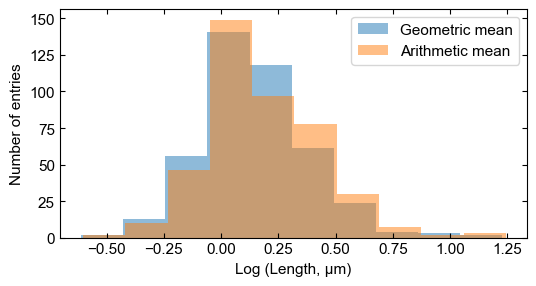

In [150]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bm5['length_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_bm5['length_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Length, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

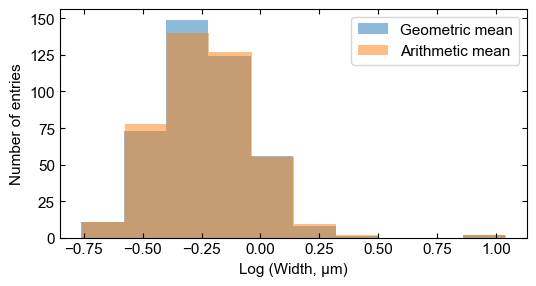

In [151]:
plt.figure(figsize = (5.5, 3))
plt.hist(df_bm5['width_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
plt.hist(df_bm5['width_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
plt.xlabel(f'Log (Width, {mu}m)')
plt.ylabel('Number of entries')
plt.legend()
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

Drop species already present in BacDive

In [152]:
df_bm5 = df_bm5.drop([20, 33, 51, 52, 62, 77, 80, 90, 95, 99, 100, 124, 126, 145, 172, 332, 349, 412, 464, 486, 512, 516, 518, 519, 525, 570, 584, 596,
 609, 610, 615, 616, 617, 618, 620, 621, 632, 635, 639, 640, 642, 660, 676, 698, 701, 704, 708, 709, 717, 728, 730, 732, 736, 742, 
 743, 745, 747, 748, 749, 752, 753, 755, 756, 758, 759, 760, 761, 764, 765, 766, 772, 774, 775, 776, 777, 781, 783, 784, 785, 787, 
 788, 798, 799, 801, 805, 808, 810, 811, 820, 829, 831, 842, 843, 844, 846, 849, 850, 851, 852, 853, 855, 858, 859, 860, 863, 864, 
 865, 866, 869, 870, 871, 872, 873, 874, 875, 877, 878, 879, 882, 883, 885, 886, 889, 891, 892, 893, 895, 896, 897, 899, 904, 912, 
 914, 915])

In [153]:
df_bm5.shape

(290, 11)

Calculate volume and surface area

In [154]:
df_bm5['volume_gmean'] = np.pi * (df_bm5['width_gmean'] / 2) ** 2 * ((4 / 3) * (df_bm5['width_gmean'] / 2) + (df_bm5['length_gmean'] - df_bm5['width_gmean']))
df_bm5['surface_gmean'] = 2 * np.pi * (df_bm5['width_gmean'] / 2) * (2 * (df_bm5['width_gmean'] / 2) + (df_bm5['length_gmean'] - df_bm5['width_gmean']))
# df_bm5['svratio_gmean'] = df_bm5['surface_gmean'] / df_bm5['volume_gmean']
# df_bm5['vsratio_gmean'] = df_bm5['volume_gmean'] / df_bm5['surface_gmean']

In [155]:
df_bm5['volume_amean'] = np.pi * (df_bm5['width_amean'] / 2) ** 2 * ((4 / 3) * (df_bm5['width_amean'] / 2) + (df_bm5['length_amean'] - df_bm5['width_amean']))
df_bm5['surface_amean'] = 2 * np.pi * (df_bm5['width_amean'] / 2) * (2 * (df_bm5['width_amean'] / 2) + (df_bm5['length_amean'] - df_bm5['width_amean']))
# df_bm5['svratio_amean'] = df_bm5['surface_amean'] / df_bm5['volume_amean']
# df_bm5['vsratio_amean'] = df_bm5['volume_amean'] / df_bm5['surface_amean']

Get ranges

In [156]:
df_bm5['length_ranges'] = df_bm5['Length'].astype(str).apply(size_to_range)
df_bm5['width_ranges'] = df_bm5['Width'].astype(str).apply(size_to_range)

Fix ranges

In [157]:
df_bm5['length_ranges_fix'] = df_bm5.apply(lambda x: order(x, 'length'), axis = 1)
df_bm5['width_ranges_fix'] = df_bm5.apply(lambda x: order(x, 'width'), axis = 1)

Save dataframe

In [158]:
# Set a new index
df_bm5.set_index(np.arange(0, df_bm5.shape[0]), inplace = True)

In [182]:
df_bm5['Name'] = df_bm5['Name'].map(lambda x: x.split()[0].capitalize() + ' ' + x.split()[1])
df_bm5.shape

(290, 19)

In [183]:
df_bm5.to_csv('preprocess/data_bm5.tsv', sep = '\t')

Combine volumes into a single dataset

In [160]:
# df_bm = pd.concat([df_bm1, df_bm4, df_bm5])
# df_bm.shape

Standardize length and width values:

* For ranges (e.g., `4-8`), take geometric mean
* For minimum / maximum values, take boundary.
* There are some exceptions. The following code deals with exceptions.

In [161]:
# df_bm['length_gmean'] = df_bm['Length'].astype(str).apply(size_to_num)
# df_bm['width_gmean'] = df_bm['Width'].astype(str).apply(size_to_num)

In [162]:
# df_bm['length_amean'] = df_bm['Length'].astype(str).apply(size_to_num2)
# df_bm['width_amean'] = df_bm['Width'].astype(str).apply(size_to_num2)

Ensure that length is greater than or equal to width.

In [163]:
# df_bm[['length_gmean', 'width_gmean']] = df_bm[['length_gmean', 'width_gmean']].apply(
#     lambda x: pd.Series([max(x), min(x)]), axis = 1)

In [164]:
# df_bm[['length_amean', 'width_amean']] = df_bm[['length_amean', 'width_amean']].apply(
#     lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

In [165]:
# plt.figure(figsize = (5.5, 3))
# plt.hist(df_bm['length_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
# plt.hist(df_bm['length_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
# plt.xlabel(f'Log (Length, {mu}m)')
# plt.ylabel('Number of entries')
# plt.legend()
# plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
# plt.show()

In [166]:
# plt.figure(figsize = (5.5, 3))
# plt.hist(df_bm['width_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
# plt.hist(df_bm['width_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
# plt.xlabel(f'Log (Width, {mu}m)')
# plt.ylabel('Number of entries')
# plt.legend()
# plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
# plt.show()

Calculate volume and surface area

In [167]:
# df_bm['volume_gmean'] = np.pi * (df_bm['width_gmean'] / 2) ** 2 * ((4 / 3) * (df_bm['width_gmean'] / 2) + (df_bm['length_gmean'] - df_bm['width_gmean']))
# df_bm['surface_gmean'] = 2 * np.pi * (df_bm['width_gmean'] / 2) * (2 * (df_bm['width_gmean'] / 2) + (df_bm['length_gmean'] - df_bm['width_gmean']))
# df_bm['svratio_gmean'] = df_bm['surface_gmean'] / df_bm['volume_gmean']
# df_bm['vsratio_gmean'] = df_bm['volume_gmean'] / df_bm['surface_gmean']

In [168]:
# df_bm['volume_amean'] = np.pi * (df_bm['width_amean'] / 2) ** 2 * ((4 / 3) * (df_bm['width_amean'] / 2) + (df_bm['length_amean'] - df_bm['width_amean']))
# df_bm['surface_amean'] = 2 * np.pi * (df_bm['width_amean'] / 2) * (2 * (df_bm['width_amean'] / 2) + (df_bm['length_amean'] - df_bm['width_amean']))
# df_bm['svratio_amean'] = df_bm['surface_amean'] / df_bm['volume_amean']
# df_bm['vsratio_amean'] = df_bm['volume_amean'] / df_bm['surface_amean']

Get ranges

In [169]:
# df_bm['length_ranges'] = df_bm['Length'].astype(str).apply(size_to_range)
# df_bm['width_ranges'] = df_bm['Width'].astype(str).apply(size_to_range)

Fix ranges

In [170]:
# df_bm['length_ranges_fix'] = df_bm.apply(lambda x: order(x, 'length'), axis = 1)
# df_bm['width_ranges_fix'] = df_bm.apply(lambda x: order(x, 'width'), axis = 1)

# Plots

In [171]:
# fig, ax = plt.subplots(2, 3, figsize = (15, 4), 
#                        sharey = False, sharex = True)

# for i, metric in enumerate(['length', 'width']):
#     for j, source in enumerate([df_bacd, df_pcc, df_bm]):
#         ax[i, j].hist(source[f'{metric}_gmean'].apply(np.log10), alpha = 0.5, label = 'Geometric mean')
#         ax[i, j].hist(source[f'{metric}_amean'].apply(np.log10), alpha = 0.5, label = 'Arithmetic mean')
#         ax[i, j].legend()
#         ax[i, j].set_xlabel(f'Log ({metric}, {mu}m)')
#         ax[i, j].set_title(f'{j}')
#         ax[i, j].tick_params(top = True, right = True, direction = 'in', which = 'both')

In [172]:
# test = df_bm.sort_values(by = ['width_gmean'])[['Name', 'Length', 'Width', 'length_gmean', 'width_gmean', 'length_amean', 'width_amean']]

In [173]:
# test['log_width_gmean'] = test['width_gmean'].apply(np.log10)
# test['log_width_amean'] = test['width_amean'].apply(np.log10)

In [174]:
# test.head(n = 60)

**The choice of mean does produce a different result for ranges that expand two orders of magnitude, with the geometric mean assigning lower values compared to the arithmetic mean. The species most affected are *Mycoplasma***

In [175]:
# np.random.seed(42)

# ranges = df_pubmed['length_ranges_fix'].apply(lambda x: (np.log10(x[0]), np.log10(x[1]))).to_numpy() 
# means = df_pubmed['length_gmean'].apply(np.log10).to_numpy()

# # Sample points
# n = 50
# sample_indices = np.random.choice(len(means), size = n, replace = False)
# sampled_means = means[sample_indices]
# sampled_ranges = ranges[sample_indices]

# # Extract start and end points from ranges
# err = [(end - start) / 2 for start, end in sampled_ranges]

# # Violin plot
# violins = plt.violinplot(means, showmeans = False, showextrema = False)
# for pc in violins['bodies']:
#     pc.set_facecolor('#d5ccc7')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)    
# quartile1, medians, quartile3 = np.percentile(means, [25, 50, 75])
# plt.scatter(1, np.mean(means), marker = 'o', color = 'black', s = 100, zorder = 3)


# # Individuals means and ranges
# # plt.scatter(np.random.normal(1, 0.03, len(sampled_means)), sampled_means,
# #             c = '#ef476f', alpha = 1)
# x_noise = np.random.normal(1, 0.03, len(sampled_means))
# plt.errorbar(x_noise, sampled_means, yerr = err, fmt = 'o',
#              capsize = 4, alpha = 0.6, color = '#26547c')
# # plt.xlabel('Range Mean')
# plt.ylabel(f'Log (Length {mu}m)')
# plt.show()


In [176]:
# np.random.seed(42)

# ranges = df_bm['width_ranges_fix'].apply(lambda x: (np.log10(x[0]), np.log10(x[1]))).to_numpy() 
# means = df_bm['width_gmean'].apply(np.log10).to_numpy()

# # Sample points
# n = 50
# sample_indices = np.random.choice(len(means), size = n, replace = False)
# sampled_means = means[sample_indices]
# sampled_ranges = ranges[sample_indices]

# # Extract start and end points from ranges
# err = [(end - start) / 2 for start, end in sampled_ranges]

# # Violin plot
# violins = plt.violinplot(means, showmeans = False, showextrema = False)
# for pc in violins['bodies']:
#     pc.set_facecolor('#d5ccc7')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)    
# quartile1, medians, quartile3 = np.percentile(means, [25, 50, 75])
# plt.scatter(1, np.mean(means), marker = 'o', color = 'black', s = 100, zorder = 3)


# # Individuals means and ranges
# # plt.scatter(np.random.normal(1, 0.03, len(sampled_means)), sampled_means,
# #             c = '#ef476f', alpha = 1)
# x_noise = np.random.normal(1, 0.03, len(sampled_means))
# plt.errorbar(x_noise, sampled_means, yerr = err, fmt = 'o',
#              capsize = 4, alpha = 0.6, color = '#26547c')
# # plt.xlabel('Range Mean')
# plt.ylabel(f'Log (Width {mu}m)')
# plt.show()


# Plot

In [177]:
# data = [df_bacd, df_pcc, df_pubmed, df_bm]
# ranges = []
# means = []
# for datum in data:
#     ranges.append(datum['width_ranges_fix'].apply(lambda x: (np.log10(x[0]), np.log10(x[1]))).to_numpy())
#     means.append(datum['width_gmean'].apply(np.log10).to_numpy())

In [178]:
# ranges = np.array(ranges, dtype = object)
# means = np.array(means, dtype = object)

In [179]:
# colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261']

In [180]:
# np.random.seed(42)

# plt.figure(figsize = (11, 5))

# # Violinplot
# violins = plt.violinplot(means, showextrema = False)
# for i, pc in enumerate(violins['bodies']):
#     pc.set_facecolor(colors[i])
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)  
# mus = [np.mean(x) for x in means]
# inds = np.arange(1, len(mus) + 1)
# plt.scatter(inds, mus, marker = 'o', color = 'white', s = 100, zorder = 3)

# # Sample individual points for cell size
# n = 50
# for i, m, r in zip(inds, means, ranges):
#     sample_indices = np.random.choice(len(m), size = n, replace = False)
#     sampled_means = m[sample_indices]
#     sampled_ranges = r[sample_indices]
#     # Scatter plot
#     x_noise = np.random.normal(i, 0.03, len(sampled_means))
#     plt.errorbar(x_noise, sampled_means, yerr = err, fmt = 'o',
#              capsize = 4, alpha = 0.6, color = 'k', zorder = 2)
    
# plt.xticks(inds, 
#            [f'Bacdive\n(n = {len(means[0])})', f'PCC\n(n = {len(means[1])})', 
#             f'PubMed\n(n = {len(means[2])})', f'Bergey\'s Manual\n(n = {len(means[3])})'])

# plt.show()